In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import sys
import tarfile
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import h5py
import skimage
from skimage.io import imread, imsave
from skimage.transform import resize

%matplotlib inline 

/home/josh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# preprocessing train data

In [2]:
filename = 'train.tar.gz'

In [3]:
root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz

In [4]:
file_list =[root + '/' + x for x in os.listdir(root) ]

decompress training data to folder 'train'

In [5]:
tar = tarfile.open(filename)
sys.stdout.flush()
tar.extractall()
tar.close()

In [6]:
png_info = [s for s in file_list if '.mat' in s]

info_file is 'digit_struct.mat'

In [7]:
info_file = png_info[0]

In [8]:
f = h5py.File(info_file,'r')

In [9]:
for name in f:
    print name

#refs#
digitStruct


# extract information from matadata

In [10]:
metadata= {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(obj[0][0])
    else:
        for k in range(obj.shape[0]):
            vals.append(f[obj[k][0]][0][0])
    metadata[name].append(vals)

In [11]:
for item in f['/digitStruct/bbox']:
    f[item[0]].visititems(print_attrs)

In [12]:
metadata.keys()

['width', 'top', 'label', 'left', 'height']

# pickle the extracted metadata

In [13]:
pickle_file = 'train_metadata.pickle'
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(metadata, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [14]:
img = imread('train/1.png')

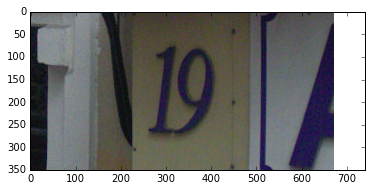

In [15]:
plt.imshow(img)
plt.show()

# read metadata from pickle file

In [16]:
pickle_file = 'train_metadata.pickle'

metadata={}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    metadata['height'] = save['height']
    metadata['label'] = save['label']
    metadata['left'] = save['left']
    metadata['top'] = save['top']
    metadata['width'] = save['width']
    del save  # hint to help gc free up memory

In [17]:
metadata['label'][:2]

[[1.0, 9.0], [2.0, 3.0]]

# Resize image and change corresponding metadata

In [18]:

def resize_and_boxes(img, new_size=[32,32], top=[5,5], left=[5,5], height=[30,30],width=[30,30]):
    img_resize = skimage.transform.resize(img, new_size)
    
    v_factor = 1.0*new_size[0]/img.shape[0]
    new_top = v_factor * np.asarray(top) 
    new_height = v_factor*np.asarray(height)
    
    new_bottom = new_top + new_height
    new_top = np.floor(new_top)
    new_height = np.ceil(new_bottom - new_top)
    
    h_factor = 1.0 * new_size[1]/img.shape[1]
    new_left = h_factor * np.asarray(left) 
    new_width = h_factor * np.asarray(width)
    
    new_right = new_left + new_width
    new_left = np.floor(new_left)
    new_width = np.ceil(new_right - new_left)
    
    new_box = {'top': new_top.tolist(), 'left': new_left.tolist(),
               'height':new_height.tolist(), 'width':new_width.tolist()}

    return img_resize, new_box

In [19]:

img_resize, new_box = resize_and_boxes(img, top=metadata['top'][0], left = metadata['left'][0], 
                                       height=metadata['height'][0], width = metadata['width'][0])

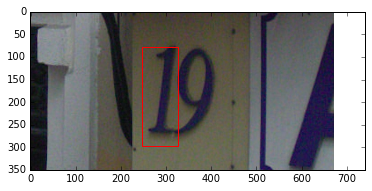

In [20]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((metadata['left'][0][0],metadata['top'][0][0]),
                         metadata['width'][0][0],metadata['height'][0][0],
                         linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

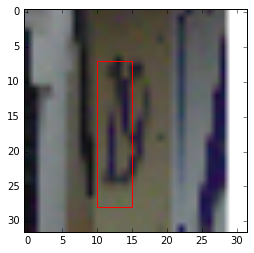

In [21]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_resize)

# Create a Rectangle patch
rect = patches.Rectangle((new_box['left'][0],new_box['top'][0]),
                         new_box['width'][0],new_box['height'][0],
                         linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [22]:
new_box

{'height': [21.0, 21.0],
 'left': [10.0, 13.0],
 'top': [7.0, 7.0],
 'width': [5.0, 6.0]}

# Generate a small data set

In [23]:
#mini train
mini_size = 1000
image_size = [64,64]

file_list = ['train/' + str(x+1) + '.png' for x in range(mini_size)]

mini_dataset = np.ndarray(shape=(len(file_list), image_size[0], image_size[1], 3), dtype=np.float32)
mini_outcome = {}
mini_outcome['left']=[]
mini_outcome['top']=[]
mini_outcome['height']=[]
mini_outcome['width']=[]
mini_outcome['label']=[]

for i in range(mini_size):
    img = imread(file_list[i])
    img_resize, new_box = resize_and_boxes(img, new_size=image_size, top=metadata['top'][i], 
                                           left = metadata['left'][i], height=metadata['height'][i], 
                                           width = metadata['width'][i])
    mini_dataset[i,:,:,:] = img_resize
    
    mini_outcome['label'].append(metadata['label'][i])
    
    for name in new_box.keys():
        mini_outcome[name].append(new_box[name])

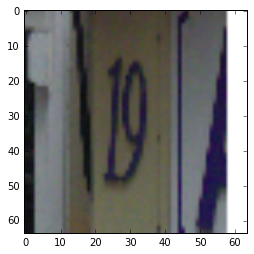

In [24]:
plt.imshow(mini_dataset[0,:,:,:])
plt.show()

## pickle the small data set for later use

In [25]:
pickle_file = 'mini_train.pickle'
mini_train = {'data':mini_dataset, 'outcome':mini_outcome}
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(mini_train, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [26]:
pickle_file = 'mini_train.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    mini_X = save['data']
    mini_outcome = save['outcome']
    del save  # hint to help gc free up memory

In [27]:
mini_X.shape

(1000, 64, 64, 3)

In [28]:
print mini_outcome['label'][:10]

[[1.0, 9.0], [2.0, 3.0], [2.0, 5.0], [9.0, 3.0], [3.0, 1.0], [3.0, 3.0], [2.0, 8.0], [7.0, 4.0, 4.0], [1.0, 2.0, 8.0], [1.0, 6.0]]
